원본: <a href='https://www.kaggle.com/morrisb/how-to-recommend-anything-deep-recommender'>캐글 노트북</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os 
os.chdir('/Users/younghun/Desktop/gitrepo/data')

# Load datasets

## Movie-data

In [2]:
# 넷플릭스에 있는 영화들 데이터( 변수이름 없어서 header=None 설정해야 함)
#names로 header 직접 설정
movie_titles = pd.read_csv("./netflix/movie_titles.csv",
                          encoding='ISO-8859-1',
                          header= None,
                          names=['Id','Year','Name']).set_index('Id')
print("Shape of Netflix movie dataset :", movie_titles.shape)
# 5개 데이터 무작위로 샘플링해보기
movie_titles.sample(5)

Shape of Netflix movie dataset : (17770, 2)


Year                           Name
Id                                          
8952   2001.0                     Soulkeeper
12182  1942.0                 Random Harvest
42     2002.0         Searching for Paradise
2546   1995.0              The Second Coming
2779   2003.0  Dr. Seuss' The Cat in the Hat

In [3]:
movie_titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17770 entries, 1 to 17770
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    17763 non-null  float64
 1   Name    17770 non-null  object 
dtypes: float64(1), object(1)
memory usage: 416.5+ KB


In [4]:
# low_memory=True이면 더 적은 메모리를 사용하여 데이터 로드를 하지만 
# 변수별 dtype를 추론해 mixed type을 유발할 수 있음
movie_metadata = pd.read_csv('./movie_dataset/movies_metadata.csv',
                            low_memory=True)

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning:

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.



In [5]:
# 영화 제목, 영화에 대한 개요, vote_count 변수만 추출
movie_metadata = pd.read_csv('./movie_dataset/movies_metadata.csv',
                            low_memory=False)[['original_title',
                                              'overview',
                                              'vote_count']].set_index('original_title').dropna()

In [6]:
# 거의 평가되지 않은 vote_count가 10이하인 long tail부분을 제거하기!
# 그리고 vote_count 변수도 삭제
movie_metadata = movie_metadata[movie_metadata['vote_count'] > 10].drop('vote_count', axis=1)
print("A shape of movie-metadata :", movie_metadata.shape)
movie_metadata.sample(5)

A shape of movie-metadata : (21604, 1)


overview
original_title                                                         
They Were Expendable  Shortly after Pearl Harbor, a squadron of PT-b...
बदलापुर               After his wife and son are killed, a young man...
Prince of Darkness    A research team finds a mysterious cylinder in...
Le Jaguar             A shaman from the South American rain forest v...
The Hills Have Eyes   Based on Wes Craven's 1977 suspenseful cult cl...

## User-data

In [7]:
# usecols= list : 불러올 변수(변수 인덱스 or 변수 이름써도 됨)
df_raw = pd.read_csv('./netflix/combined_data_1.txt',
                    header=None,
                    names=['User','Rating','Date'],
                    usecols=[0, 1, 2])
df_raw.head(2)

User  Rating        Date
0  1488844     3.0  2005-09-06
1   822109     5.0  2005-05-13

In [8]:
# Rating이 비어있는 영화 찾기
tmp_movies = df_raw[df_raw['Rating'].isnull()]['User'].reset_index()
tmp_movies.head(3)

index User
0    547   2:
1    693   3:
2   2706   4:

In [9]:
# 영화 indices => [인덱스, 영화]
# movie[:-1] 하는 이유는 colon(:) 빼고 추출하기 위한 것임!
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

In [10]:
# 처음 index를 맨 뒤 index로 보내기.. 왼쪽으로 한 칸 움직이기!
from collections import deque
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

In [11]:
# 모든 데이터 프레임 담을 빈 리스트 정의
user_data = []

# 모든 영화에 대해 iteration
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # 인덱스 순서를 이용해서 마지막 영화인지 체크
    if df_id_1 < df_id_2:
        # df_id_1인덱스 다음부터 df_id_2이전 인덱스까지 
        tmp_df = df_raw.loc[df_id_1+1: df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
    
    tmp_df['Movie'] = movie_id
    user_data.append(tmp_df)

df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(5)

Shape User-Ratings:	(24053217, 4)


User  Rating        Date  Movie
6632753    169485     5.0  2005-06-29   1307
5171753    345800     3.0  2005-03-21   1046
14665834  1602117     1.0  2005-05-09   2813
12403874  1235037     3.0  2004-08-04   2388
10902673    72345     4.0  2005-07-04   2122

## 영화들이 언제 개봉됬는지?

In [12]:
# plotly 시각화 라이브러리
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [13]:
data = movie_titles['Year'].value_counts().sort_index()

# Plotly에서 Scatter은 Line 그래프임!
trace = go.Scatter(x=data.index, y=data.values,
                  marker=dict(color='#db0000'))
# layout of plot 설정
layout = {'title':f"{movie_titles.shape[0]} Movies Grouped by year of Release",
         'xaxis': {
             'title': 'Release Year'
         },
         'yaxis':{
             'title': 'Movies'
         }
         }

fig = go.Figure(data=trace, layout=layout)
iplot(fig)


- 2000년대에 많은 영화가 출시되었다.
- 맨 오른쪽 부분은 2000년 완전한 1년이 기록된 데이터가 아니기 때문에 감소하는 것으로 보임

## 영화 평점들의 분포 살펴보기

In [14]:
# index 내림차순 정렬도 가능
data = df['Rating'].value_counts().sort_index(ascending=False)

# Bar graph
trace = go.Bar(x=data.index,
              y=data.values,
              text=[f"{val :.1f}"for val in (data.values/df.shape[0]*100)],
              textposition='auto',
              textfont={'color':'#000000'},
              marker={'color':'#db0000'})
layout = {'title':f"Distribution of {df.shape[0]} Netflix-Ratings",
         'xaxis':{
             'title':'Rating'
         },
         'yaxis':{
             'title':'Count'
         }}

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

- 평점이 bias가 있는 듯한 분포를 띈다. 대부분 높은 평점을 보이는 이유는 다음과 같다. 그 영화를 좋아하는 사람들만 정말 좋아한다고 평가했지, 마음에 들어하지 않는 고객들은 평점을 매기지 않은 채 떠났을 것이기 때문이다..!

## 영화는 언제 평점이 매겨졌는가?

In [15]:
data = df['Date'].value_counts()
# index 타입을 datetime 형태로 바꿔주기
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)

trace = go.Scatter(x=data.index,
                  y=data.values,
                  marker={'color':'#db0000'})
layout = {'title': f"{df.shape[0]} Movie-ratings grouped by Day",
         'xaxis':{
             'title':'Date'
         },
         'yaxis':{
             'title':'Ratings'
         }}
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

- 2005년 11월 이후로 영화 평점 개수가 감소했다
- 2005년 1월과 4월 비이상적인 peak가 발생한게 이상한 점

## 각 영화, 유저마다 평점 개수의 분포는 어떨까?

In [16]:
# 하나의 영화당 평점 group by하기(단, Rating 개수가 9999개 이하인 것들만!)
data = df.groupby('Movie')['Rating'].count().clip(upper=9999)

trace = go.Histogram(x=data.values,
                    name='Ratings',
                    xbins={'start':0,
                          'end':10000,
                          'size':100},
                    marker={'color': '#db0000'})
# go.Layout()없이 dict로만 layout정의해주어도 에러발생하지 않음!
layout = go.Layout({'title':'Distribution of Rating count per movie',
                   'xaxis':{
                       'title':'Ratings per movie'
                   },
                   'yaxis':{
                       'title':'Count'
                   },
                   'bargap':0.2}
                  )
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

In [17]:
# 하나의 유저당 평점 개수 group by하기
data = df.groupby('User')['Rating'].count().clip(upper=199)

#plot
trace = go.Histogram(x=data.values,
                    name='Ratings',
                    xbins={'start':0,
                          'end':200,
                          'size':2},
                    marker={'color':'#db0000'})
#layout
layout = go.Layout({'title':'Distribution of rating count per user',
                   'xaxis':{
                       'title':'Ratings per user'
                   },
                   'yaxis':{
                       'title':'Counts'
                   },
                   'bargap':0.2})
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

영화, 평점 둘다 지수분포형태를 띄고 있다. 즉, 극 소수의 영화와 유저들만이 많은 평점을 갖고 있다는 의미!

## 평점이 거의 없는 유저와 영화 데이터 삭제

In [18]:
### 영화 삭제
min_movie_ratings = 10000
# Pandas Series value에 조건을 붙여 boolean으로 만들수 있음
filter_movies = (df['Movie'].value_counts() > min_movie_ratings)
print(type(filter_movies))
# True인 index만 갖고와서 list로 만들기 -> 왜 []를 덮어씌울까..?
filter_movies = filter_movies[filter_movies].index.tolist()

### 유저 삭제
min_user_ratings = 200
filter_users = (df['User'].value_counts() > min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

<class 'pandas.core.series.Series'>


In [19]:
# 두 조건을 만족하는 데이터들만 가져오기
df_filtered = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]

# 사용하지 않는 변수 삭제
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print("Befor filtering, Shape of dataframe: ", df.shape)
print("After filtering, Shape of dataframe: ", df_filtered.shape)

Befor filtering, Shape of dataframe:  (24053217, 4)
After filtering, Shape of dataframe:  (4177876, 4)


## Train, Test 데이터셋 만들기

In [20]:
# sample(frac=1)을 이용해 데이터 shuffle해주기
df_filtered = df_filtered.drop(['Date'], axis=1).sample(frac=1).reset_index(drop=True)

# Test size
n = 100000

# Split train, test
df_train = df_filtered[:-n]
df_test = df_filtered[-n:]
print("Train:", df_train.shape)
print("Test:", df_test.shape)

Train: (4077876, 3)
Test: (100000, 3)


## User-ratings => User-Moive로 변환하기

- 크고 희소한 행렬이 도출됨. 여기서 빈값들(아직 평가되지 않은 것들)을 추정하기 위한 것이 우리의 목표이다!

In [21]:
df_p = df_train.pivot_table(index='User', columns='Movie',
                    values='Rating')
print("A matrix-shape of User-Movie:", df_p.shape)
df_p.sample(3)

A matrix-shape of User-Movie: (20827, 491)


Movie    8     18    28    30    58    77    83    97    108   111   ...  \
User                                                                 ...   
2041854   NaN   5.0   NaN   4.0   4.0   NaN   5.0   4.0   4.0   NaN  ...   
1616634   NaN   NaN   4.0   NaN   3.0   NaN   NaN   NaN   NaN   NaN  ...   
1261789   NaN   4.0   NaN   4.0   3.0   NaN   NaN   3.0   NaN   NaN  ...   

Movie    4392  4393  4402  4418  4420  4432  4472  4479  4488  4490  
User                                                                 
2041854   NaN   4.0   4.0   NaN   4.0   4.0   4.0   5.0   NaN   4.0  
1616634   3.0   3.0   NaN   3.0   NaN   5.0   4.0   NaN   NaN   NaN  
1261789   4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[3 rows x 491 columns]

# 추천 시스템 모델링

## Mean rating

- 각 영화들에 대해 평가된 유저들의 평점들을 평균값 내는 것은 영화들 간의 순위를 만들어낼 수 있다. 이것은 **유저들에 대한 정보 없이 사용될 수 있음**
- 이로 부터 파생될 수 있는 또 다른 변수들은 각 나라, 연령, 성별 등에 대해 각각 분리된 랭킹을 만들수 있고 이러한 파생된 랭킹들에 기반해 영화를 유저에게 추천하기 위해 개별적으로 사용될 수 있음!

- 하지만 이러한 방법은 biased된 접근이다. 왜냐하면 매우 인기있는 영화들에 대해 제대로 평가되지 않기 때문이다. 즉, 많은 평가를 받은 영화들은 **평균 평점**이라는 척도에서 extreme하게 반영되지 않기 때문이다

In [22]:
n = 10

# 각 영화들에 대해 유저들의 평균평점
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('Rating-mean').to_frame()

# 각 영화들에 대해 유저들이 평가한 평점 개수 count
ratings_count = df_p.count(axis=0).rename('Rating-count').to_frame()

In [23]:
# 위에서 만든 평균평점에서 상위 n개를 뽑은 다음 그에 해당하는 영화의 평점 개수 join하기
# 그리고 또 movie_titles에서 Movie Id(index)에 해당하는 영화 이름도 join하기
ranking_mean_rating = ratings_mean.head(n).join(ratings_count).join(movie_titles.drop('Year', axis=1))
ranking_mean_rating

Rating-mean  Rating-count  \
Movie                              
3444      4.437276          2790   
2452      4.426844         18440   
2172      4.382979          6157   
1256      4.372887          2899   
3962      4.369187         17376   
3046      4.348613          4974   
1476      4.346079          2563   
4306      4.332604         19188   
3290      4.325098         13073   
2162      4.324068          4533   

                                                Name  
Movie                                                 
3444           Family Guy: Freakin' Sweet Collection  
2452   Lord of the Rings: The Fellowship of the Ring  
2172                          The Simpsons: Season 3  
1256                     The Best of Friends: Vol. 4  
3962                       Finding Nemo (Widescreen)  
3046               The Simpsons: Treehouse of Horror  
1476                        Six Feet Under: Season 4  
4306                                 The Sixth Sense  
3290                                   The Godfather  
2162                                   CSI: Season 1

- 위 평점 평균은 Train 데이터에 기반해서 만든 것임!
- 이제 이를 Test 데이터에 적용해보자!

In [24]:
# label과 prediction join하기
# Train에서 만든 ratings_mean을 test에다가 join시키기
# Movie를 인덱스로 설정함으로써 이 인덱스(Movie)에 해당하는 평균 평점 join시키기
df_prediction = df_test.set_index("Movie").join(ratings_mean)[['Rating','Rating-mean']]
y_true = df_prediction['Rating']
y_pred = df_prediction['Rating-mean']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

0.9931621891046399

In [25]:
trace = go.Bar(x=ranking_mean_rating['Rating-mean'],
              text=ranking_mean_rating['Name'].astype(str)+':'+ranking_mean_rating['Rating-count'].astype(str)+'Ratings',
              textposition='outside',
              textfont={'color':'#000000'},
              orientation='h',
              y=[a for a in range(1, n+1)],
              marker={'color':'#db0000'})
layout = {'title':f"Ranking of top {n} Mean-movie-ratings:{rmse:.3f} RMSE",
         'xaxis':{
             'title':'Mean-rating',
             'range':(4.3, 4.55)
         },
         'yaxis':{
             'title':'Movie'
         }}
fig = go.Figure(data=trace, layout=layout)
iplot(fig)

## Weighted Mean Rating

- 평점이 없는 것들에 대한 불안정한 평균값 문제를 해결하기 위해 weighted rating 공식을 사용할 예정

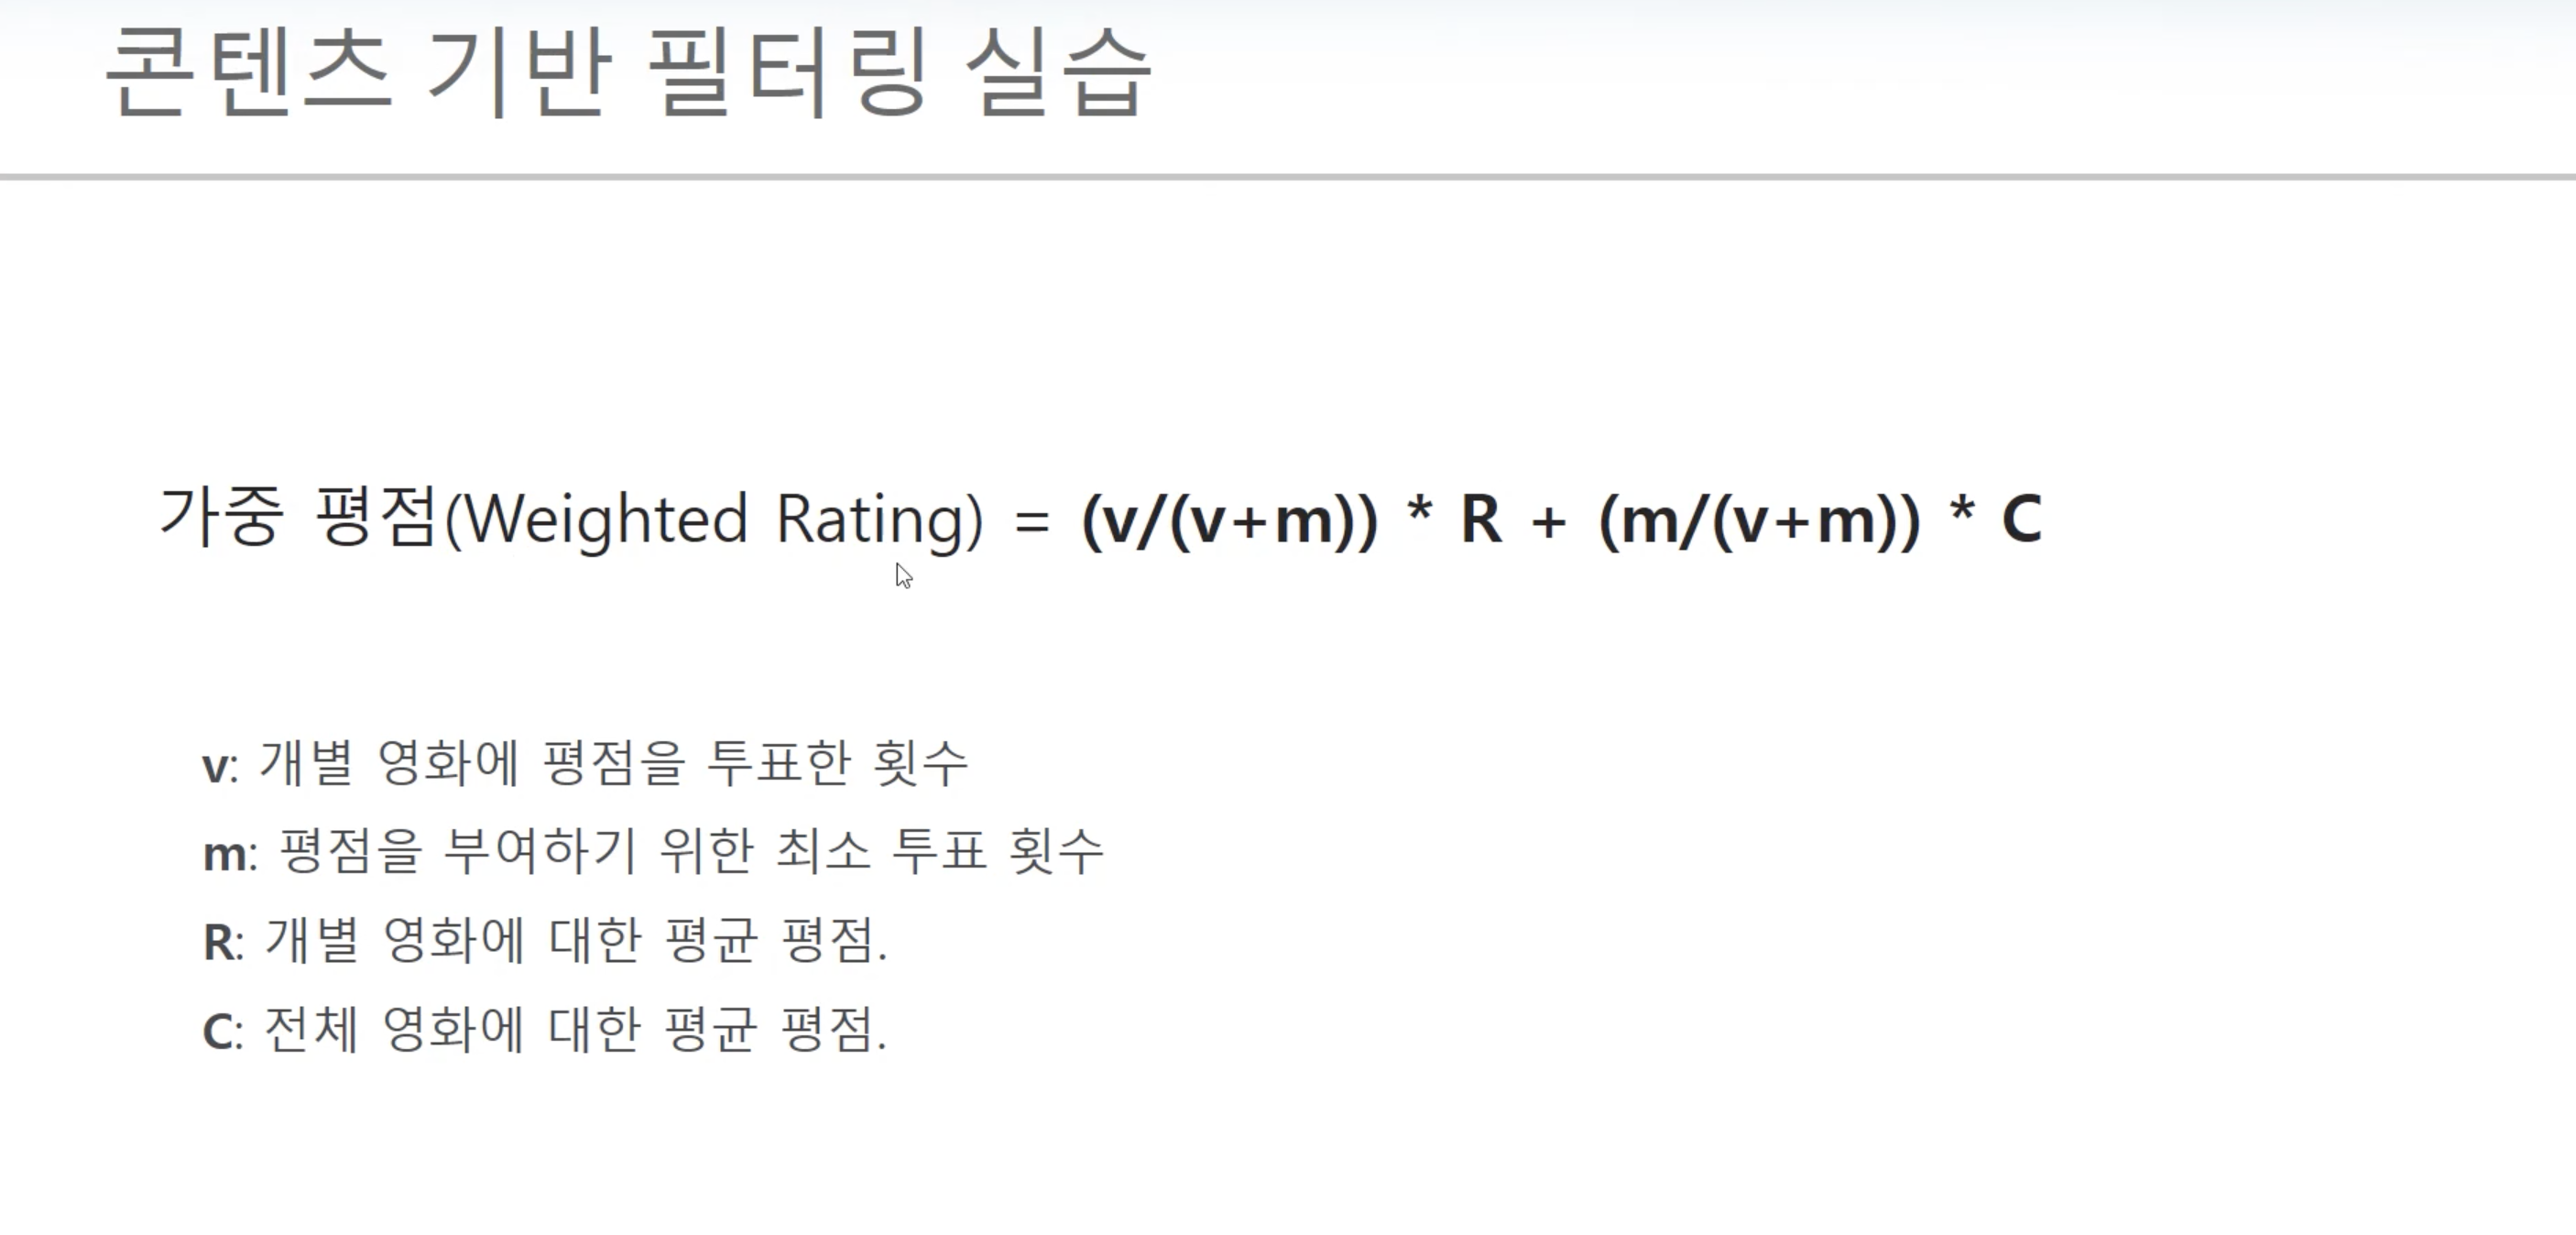

In [26]:
from IPython.display import Image
Image('/Users/younghun/Desktop/강의자료/인프런_머신러닝강의/강의자료스샷/추천/컨텐츠기반/가중평점계산공식.png')

In [34]:
# 평점 부여하기 위한 최소 투표 횟수
m = 1000
# 전체 영화에 대한 평균 평점
C = df_p.stack().mean()
# 각 영화에 대한 평균 평점(영화가 칼럼에 있으므로 행 방향쪽으로 평균 계산하므로 axis=0
R = df_p.mean(axis=0).values # 491개의 영화 shape: (491,)
# 각 영화에 대해 매겨진 평점 개수
v = df_p.count(axis=0).values # 491개의 영화 shape: (491,)

In [36]:
# 각 영화에 대해 가중치가 부여된 스코어 만들기 shape: (491,)
weighted_score = (v / (v+m) * R) + (m / (v+m) * C)
weighted_score.shape

(491,)

In [38]:
# 현재 각 칼럼에 영화id가 매핑되어 있기 때문에 index를 활용해보자!
# weighted_score가 높은 값을 기준으로 index 정렬
weighted_ranking = np.argsort(weighted_score)[::-1]
weighted_score = np.sort(weighted_score)[::-1]

# weighted_score가 높은 순서대로 영화제목 뽑아내기
weighted_movie_ids = df_p.columns[weighted_ranking]

In [42]:
# 인덱스를 공통 key값으로 설정함으로써 weighted_score join 시키기
df_prediction = df_test.set_index('Movie').join(pd.DataFrame(weighted_score, index=weighted_movie_ids,
            columns=['Prediction']))[['Rating','Prediction']]
y_true = df_prediction['Rating']
y_pred = df_prediction['Prediction']

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE:{rmse :.3f}")

RMSE:0.994


In [47]:
# plot그리기 위해 데이터프레임 만들기
# 가중치가 부여된 스코어기준으로 상위 10개 영화들만 있는 데이터프레임 생성
df_plot = pd.DataFrame(weighted_score[:n], columns=['Rating'])
df_plot.index = weighted_movie_ids[:n]
ranking_mean_rating = df_plot.join(ratings_count).join(movie_titles)
# 변수 삭제
del df_plot

In [50]:
# trace
trace = go.Bar(x=ranking_mean_rating['Rating'],
              y=[a for a in range(1, n+1)],
              text=ranking_mean_rating['Name'].astype(str)+':'+ranking_mean_rating['Rating-count'].astype(str)+' Ratings',
              textposition='outside',
              textfont={'color':'#000000'},
              orientation='h',
              marker={'color':'#db0000'})

layout = {'title': f"Ranking of top {n} Weighted-movie-ratings, RMSE:{rmse :.3f}",
         'xaxis':{
             'title':'Weighted Rating',
             'range':(4.15, 4.6)
         },
         'yaxis': {
             'title':'Movie'
         }
         }

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

- ``m``이 정규화 파라미터라고 볼 수 있다. 이 값을 바꿈으로써 주어지는 weight의 크키가 달라진다고 볼 수 있음. 비록 더 나은 랭킹이 될 수 있어도 RMSE값은 약간 감소할 수 있다. 따라서 해석가능성과 예측력 사이의 trade-off 관계

## Cosine user-user similarity

- 유저들의 평점을 가지고 유사한 유저들을 파악. 그리고 특정 유저에게 비슷한 유저들이 높이 평가한 영화들을 추천해주는 것이 합리적이다.
- 하지만 빈 평점들이 존재하기 때문에, 이를 적절하게 채워주어야 한다
    * 1) 각 유저들의 평균값을 채워준다

In [64]:
# 추천해줄 user index
user_index = 0 
# 추천하기 위해 참고할 비슷한 유저들 명수
n_recommendation = 100
# n개의 추천 plot
n_plot = 10

# User-item 을 item-User로 바꾸고 평점 결측치들을 각 유저들의 평균 평점으로 대체
# 그리고 다시 User-item으로 Transpose
df_p_imputed = df_p.T.fillna(df_p.mean(axis=1)).T

# 행 벡터 즉, User들끼리 코사인 유사도 구하기
similarity = cosine_similarity(df_p_imputed.values)

In [65]:
print(df_p_imputed.shape)
print(similarity.shape) # User-User similarity

(20827, 491)
(20827, 20827)


In [ ]:
print(similarity)

In [69]:
# 동일한 유저들간의 코사인 유사도 값은 제거(대각 행렬 이용) - 하는 이유: 밑 cell에서 코사인 유사도 내림차순 정렬할 때 자기 자신값 빼기 위해!
similarity -= np.eye(similarity.shape[0])

In [71]:
# 0번 index의 유저의 다른 유저들과의 코사인 유사도 상위값순으로 index 정렬
similar_user_index = np.argsort(similarity[user_index])[::-1]
# 0번 index의 유저의 다른 유저들과의 코사인 유사도 상위값 순으로 정렬
similar_user_score = np.sort(similarity[user_index])[::-1]

In [78]:
# 0번 유저가 평가&평가하지 않은 영화평점들 중 평점이 없는 Movie들의 index를 가져오자
unrated_movies = df_p.iloc[user_index][df_p.iloc[user_index].isna()].index

In [88]:
# 유저들 간의 유사도 기준으로 추천해줄 비슷한 유저들의 100개의 영화평점들과
# 유저들 간의 유사도값 곱해주기 
# 그리고 Movie-user -> User-movie로 바꾸기
# 그리고 Movie별로 평균 평점 구하기
mean_movie_recommendations = (df_p_imputed.iloc[similar_user_index[:n_recommendation]].T * similar_user_score[:n_recommendation]).T.mean(axis=0)

In [90]:
mean_movie_recommendations[:5]

Movie
8     4.206883
18    4.234709
28    4.239091
30    4.425894
58    4.212049
dtype: float64

In [96]:
# 평가되지 않은 영화들만 가져와서 평점들을 정렬하고 movie_title 붙여주기
best_movie_recommendations = mean_movie_recommendations[unrated_movies].sort_values(ascending=False).to_frame().join(movie_titles)
best_movie_recommendations.head()

0    Year                       Name
Movie                                             
3938   4.484126  2004.0                    Shrek 2
3962   4.455923  2003.0  Finding Nemo (Widescreen)
1144   4.403089  1991.0       Fried Green Tomatoes
191    4.377571  2003.0           X2: X-Men United
1754   4.360737  1984.0            Sixteen Candles